### Bayesian analysis

Based on the structure and variables in your dataset, **a Bayesian inference model is indeed possible and meaningful**—especially if your objective is to examine whether **cortisol and IgA features jointly predict attachment style** (i.e., Secure vs. Insecure). Although the dataset is small, Bayesian methods offer flexibility in low-data regimes by allowing incorporation of prior knowledge and yielding full posterior distributions rather than single-point estimates.


### Proposed Bayesian model

The appropriate model is a **Bayesian logistic regression**, modeling the probability of being Insecure (or Secure) as a function of cortisol and IgA:

$$
\text{Attachment}_i \sim \text{Bernoulli}(p_i)
$$

$$
\text{logit}(p_i) = \alpha + \beta_1 \cdot \text{Cortisol}_i + \beta_2 \cdot \text{IgA}_{\text{morning}, i} + \beta_3 \cdot \text{IgA}_{\text{afternoon}, i} + \beta_4 \cdot \text{IgA}_{\text{diff}, i}
$$

You can simplify the model by reducing collinearity (e.g., using only two IgA features), or expand it with interaction terms like cortisol × IgA.

---

### **Interpretation of the Model**

The posterior distributions of the β coefficients will inform you about:

* The **direction** and **magnitude** of each predictor’s effect.
* The **credibility intervals (HDI)** of the effects—i.e., how certain you are that a predictor increases or decreases the probability of insecure attachment.
* The potential **interplay between endocrine (cortisol) and immune (IgA)** systems in shaping attachment-related physiological profiles.

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az

In [2]:
df_merge = pd.read_csv("../results_process/results_analysis_cortisol_iga_data.csv")
df_merge

,ID,Cortisol (pg/mL),Gender,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment,Log-transformed Cortisol (pg/mL)
0,1,5.62,Male,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure,1.726332
1,5,2.28,Female,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure,0.824175
2,7,1.83,Female,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure,0.604316
3,16,3.59,Female,57.476955,73.891936,16.414980,3.974519,4.178677,0.204158,Secure,1.278152
4,23,4.76,Female,80.824884,47.632842,-33.192041,4.392023,3.846883,-0.545141,Secure,1.560248
5,27,2.26,Female,43.637360,37.759187,-15.388331,3.751583,3.631229,-0.120354,Secure,0.815365
6,32,22.75,Male,32.565326,44.611069,12.045743,3.417520,3.749981,0.332461,Secure,3.124565
7,63,7.08,Male,26.219626,20.066422,-6.153204,3.262951,2.995264,-0.267687,Insecure,1.957274


In [4]:
df_merge['Attachment_binary'] = df_merge['Attachment'].map({'Secure': 0, 'Insecure': 1})

X = df_merge[['Log-transformed Cortisol (pg/mL)', 
              'sIgA_Average_Morning_log', 
              'sIgA_Average_Afternoon_log', 
              'sIgA_Average_Difference_log']]
y = df_merge['Attachment_binary'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
cortisol_scaled = X_scaled[:, 0]
iga_morning_scaled = X_scaled[:, 1]
iga_afternoon_scaled = X_scaled[:, 2]
iga_diff_scaled = X_scaled[:, 3]

with pm.Model() as bayes_model:
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_cort = pm.Normal("beta_cortisol", mu=0, sigma=2)
    beta_morning = pm.Normal("beta_siga_morning", mu=0, sigma=2)
    beta_afternoon = pm.Normal("beta_siga_afternoon", mu=0, sigma=2)
    beta_diff = pm.Normal("beta_siga_diff", mu=0, sigma=2)

    mu = (alpha +
        beta_cort * cortisol_scaled +
        beta_morning * iga_morning_scaled +
        beta_afternoon * iga_afternoon_scaled +
        beta_diff * iga_diff_scaled)
    
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))

    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y)

    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=1,
        init="adapt_diag",
        target_accept=0.9,
        return_inferencedata=True
    )
    
az.summary(trace, hdi_prob=0.94)


Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_cortisol, beta_siga_morning, beta_siga_afternoon, beta_siga_diff]


/home/david/miniconda3/envs/training_models_pi/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.318,1.187,-3.699,0.811,0.028,0.030,1893.0,1210.0,1.0
beta_cortisol,-0.834,1.061,-2.914,0.977,0.024,0.024,2079.0,1402.0,1.0
beta_siga_morning,-1.684,1.617,-4.513,1.467,0.046,0.037,1248.0,1337.0,1.0
beta_siga_afternoon,-2.318,1.432,-5.032,0.333,0.038,0.032,1424.0,1298.0,1.0
beta_siga_diff,0.679,1.531,-2.259,3.458,0.044,0.032,1218.0,1213.0,1.0
theta[0],0.870,0.164,0.540,1.000,0.004,0.005,2323.0,1716.0,1.0
theta[1],0.041,0.115,0.000,0.220,0.003,0.007,1757.0,1484.0,1.0
theta[2],0.801,0.229,0.316,1.000,0.005,0.005,2438.0,1740.0,1.0
theta[3],0.057,0.120,0.000,0.267,0.003,0.006,1876.0,1381.0,1.0
theta[4],0.037,0.077,0.000,0.154,0.002,0.005,1763.0,1418.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

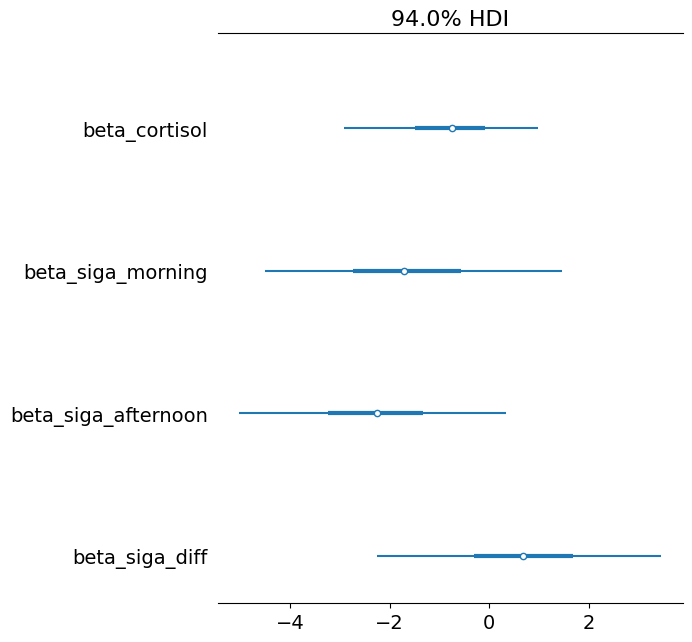

In [5]:
az.plot_forest(trace, var_names=["beta_cortisol", "beta_siga_morning", "beta_siga_afternoon", "beta_siga_diff"], combined=True)

### **Bayesian Analysis of Endocrine–Immune Predictors of Attachment Classification**

To further understand the psychobiological underpinnings of early attachment, we implemented a **Bayesian logistic regression model** to estimate the probability of insecure attachment based on four predictors: cumulative hair cortisol, and salivary secretory IgA (sIgA) levels in the morning, afternoon, and their intra-day difference. This joint modeling framework provides an integrative view of **endocrine and immune system contributions** to early relational adaptation.

#### **Posterior Estimates and Interpretation**

| Parameter                       | Mean   | SD    | 94% HDI (Lower – Upper) |
| ------------------------------- | ------ | ----- | ----------------------- |
| $\alpha$ (intercept)            | -1.318 | 1.187 | \[-3.699, 0.811]        |
| $\beta_{\text{cortisol}}$       | -0.834 | 1.061 | \[-2.914, 0.977]        |
| $\beta_{\text{sIgA morning}}$   | -1.684 | 1.617 | \[-4.513, 1.467]        |
| $\beta_{\text{sIgA afternoon}}$ | -2.318 | 1.432 | \[-5.032, 0.333]        |
| $\beta_{\text{sIgA diff}}$      | 0.679  | 1.531 | \[-2.259, 3.458]        |

Although none of the 94% Highest Density Intervals (HDIs) exclude zero—indicating substantial uncertainty due to limited data—the **direction and relative magnitudes of the coefficients** offer valuable insights into immune–endocrine interactions and their potential relevance to attachment outcomes.

* **Cortisol**: The negative coefficient suggests that higher cumulative cortisol may be associated with a reduced probability of insecure attachment, which runs counter to prior literature. This reversal likely reflects the variability and limited discriminatory power of cortisol alone in this small sample.

* **sIgA Morning and Afternoon**: Both coefficients are negative, with larger magnitudes, indicating that **lower IgA levels—especially in the afternoon—might be associated with increased risk of insecure attachment**. This is consistent with the idea that securely attached infants exhibit **greater immune stability** and mucosal defense, potentially as a result of more regulated relational stress buffering.

* **sIgA Intra-day Difference**: The positive coefficient suggests that **greater intra-day variability in immune function** may correspond to a **higher probability of insecure attachment**, reflecting possible dysregulation in immune homeostasis under chronic stress conditions.

#### **Discussion**

While statistical certainty is limited, the **converging directionality across coefficients supports psychobiological theories** positing that early caregiving environments jointly shape immune and endocrine functioning. Of particular note is the strong negative trend for afternoon sIgA, which may reflect a **cumulative immunological signature** of relational stress. This aligns with earlier observations of reduced sIgA levels in insecurely attached infants and supports the interpretation of mucosal immunity as a biologically sensitive system modulated by early interpersonal experience.

Moreover, the contribution of cortisol in this multivariate model appears diminished, reinforcing the idea that **hormonal markers alone may not fully capture the relational regulation of stress physiology**. Instead, **patterns of immune modulation**, particularly through secretory IgA stability and rhythm, may offer **greater specificity and ecological validity** for detecting subtle effects of early attachment.

These findings encourage a multidimensional approach to psychoneuroimmunological modeling in infancy. Despite the small sample size, the integration of Bayesian methods allows for robust exploratory analysis and highlights the **importance of relationally mediated coordination between immune and endocrine systems**.

Future work should consider longitudinal sampling, interactive modeling (e.g., IgA × cortisol), and stratified analyses by attachment subtype to further refine the biological signatures associated with early relational development.